# Team as an entity model

This model is a

In [1]:
# Import
from torch import nn
from torch.utils.data import DataLoader, random_split

from models.models import *
from datasets.datasets import *
from utils import *

In [2]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [3]:
file = './Data/team/processed/team_data.xlsx'
dataset = get_team_dataset(file, NL=[5])

Targets
['W%', 'L%']
Normalizing features
[]
All features
['W%', 'L%', 'GF/G', 'GA/G', 'PIM/G', 'oPIM/G', 'S%', 'SV%']
Loading player data
creating dataset structure


Dataset size: (973, 10)
Feature: W%
Feature: L%


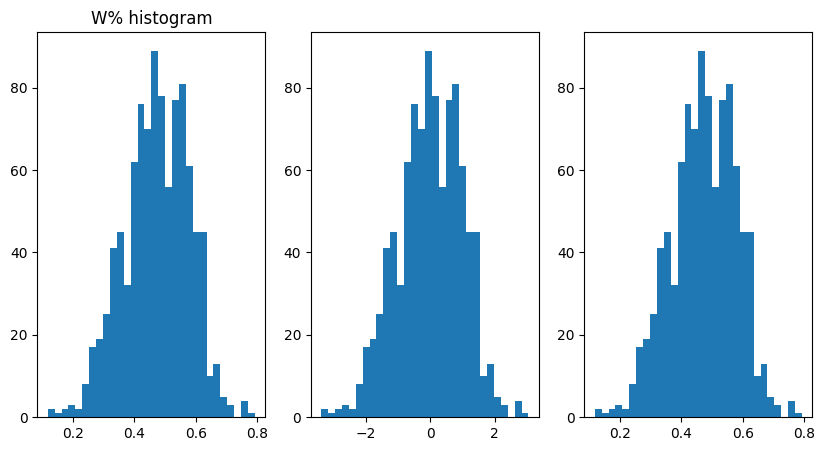

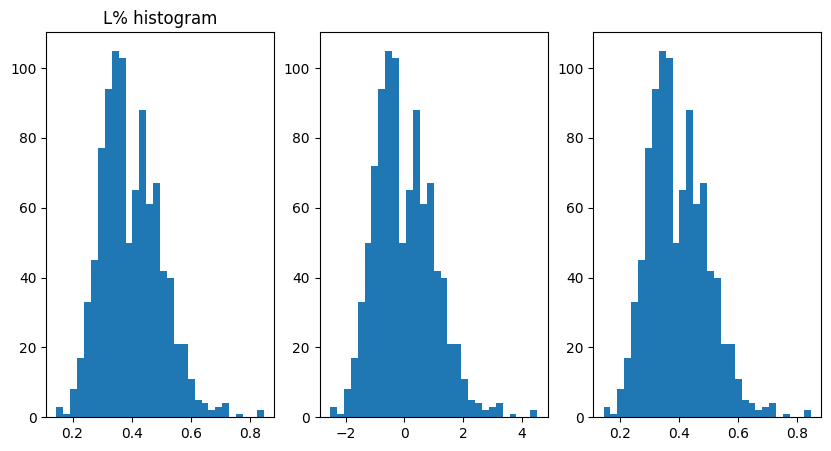

In [4]:
raw_dataset = dataset.alldata
raw_dataset_normalized = dataset.all_data_normalized

print(f"Dataset size: {raw_dataset.shape}")

for feature_name in dataset.col_names:
    if feature_name in dataset.targets:
        print(f"Feature: {feature_name}")
        feature = raw_dataset.loc[:, feature_name]
        feature_normalized = raw_dataset_normalized.loc[:, feature_name]
        features_unnormalized = dataset.unnormalize(torch.tensor(feature_normalized.values), feature_name)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.hist(feature, bins=30)
        plt.title(f"{feature_name} histogram")
        plt.subplot(1, 3, 2)
        plt.hist(feature_normalized, bins=30)
        plt.subplot(1, 3, 3)
        plt.hist(features_unnormalized, bins=30)

In [5]:
print(raw_dataset)
print(raw_dataset_normalized)

                 team name        W%        L%  GF/G  GA/G  PIM/G  oPIM/G  \
0            Boston Bruins  0.575000  0.312500  3.61  2.90   18.2    19.8   
1           Calgary Flames  0.525000  0.287500  4.35  3.31   21.9    20.3   
2           Buffalo Sabres  0.562500  0.337500  3.58  3.10   18.1    19.0   
3       Montreal Canadiens  0.512500  0.350000  3.60  2.93   19.9    20.7   
4          Edmonton Oilers  0.475000  0.350000  3.94  3.54   25.6    25.7   
..                     ...       ...       ...   ...   ...    ...     ...   
968        Ottawa Senators  0.412698  0.523810  3.17  3.51   10.9    11.6   
969  Columbus Blue Jackets  0.338462  0.507692  2.92  3.60    8.2     8.2   
970          Anaheim Ducks  0.353846  0.600000  2.58  3.62   14.3    11.9   
971     Chicago Blackhawks  0.272727  0.651515  2.18  3.55    9.0     9.9   
972        San Jose Sharks  0.250000  0.640625  2.19  3.88    9.7     8.2   

       S%    SV%  Season  
0    11.1  0.892    1990  
1    12.7  0.869    1

# Dataloader

In [6]:
batch_size = 100

# NOTE: we avoid contamination by training/testing with different players/teams
N_datasets = dataset.random_split(0.1)
dataset_train = TeamDataset(N_datasets[0][1],N=N_datasets[0][0])
dataset_test = TeamDataset(N_datasets[0][2],N=N_datasets[0][0])


# Must generate batches of sequence data with the following format:
# (batch_size, num_seasons(N), input_size(num stats))
# (https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch/49473068#49473068)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

print(dataset_train.__getitem__(0))

(tensor([[-0.4674,  0.9121,  3.0880,  2.8897,  1.7931,  1.6908,  3.7550, -3.2384],
        [ 0.9662, -0.9769,  3.1344,  0.6172,  2.7235,  3.3915,  3.5906, -0.6456],
        [-0.3479, -0.0954,  1.6019,  1.7644,  2.5297,  2.3237,  1.7822, -1.1474],
        [-0.0919,  0.1985,  2.6003,  2.5366,  2.4522,  2.5807,  1.7000, -1.7329],
        [-1.4572,  1.3979,  1.3929,  2.0513,  1.9288,  1.7699,  0.7137, -0.7292]]), tensor([-1.3435,  0.8282]))
(tensor([[-0.3479, -0.0954,  1.6019,  1.7644,  2.5297,  2.3237,  1.7822, -1.1474],
        [-0.0919,  0.1985,  2.6003,  2.5366,  2.4522,  2.5807,  1.7000, -1.7329],
        [-1.4572,  1.3979,  1.3929,  2.0513,  1.9288,  1.7699,  0.7137, -0.7292],
        [-1.3435,  0.8282,  0.1390,  1.6100,  1.1922,  0.8009,  0.0561, -0.5619],
        [-1.7320,  0.9152,  0.5105,  1.7203,  0.7269,  0.6823,  0.1383, -0.5619]]), tensor([-1.2658,  1.2838]))
(tensor([[ 1.1819, -1.2964, -0.9060, -2.2290, -0.1648, -0.3460, -1.2591,  2.1982],
        [ 1.2450, -0.4312, -0.7434,

In [7]:
print(len(N_datasets))
print(N_datasets[0][1][20])
print(len(N_datasets[0][2]))

1
(tensor([[ 1.0653, -0.5592, -0.4183, -1.2361, -0.6300, -0.9393, -1.0125,  1.0272],
        [ 0.0163,  0.3009, -1.0917, -0.9935, -0.9014, -0.8998, -1.5878,  0.1908],
        [ 0.7157, -0.4363, -0.0236, -0.9714, -0.9401, -1.0975, -0.3549,  1.4455],
        [-0.9161,  1.1610, -1.0917,  0.5730, -1.1146, -1.1568, -1.0947, -0.2274],
        [-0.5698,  1.0381, -0.8595,  0.1980, -1.3666, -1.2557, -1.7522, -0.3110]]), tensor([-0.9452,  1.0381]))
62


# Models

In [8]:
input_size = len(dataset_train.__getitem__(0)[0][0])
output_size = len(dataset_train.__getitem__(0)[1])
hidden_size = 50
#model = TeamAsEntity(input_size=input_size, hidden_size=hidden_size, device=device).to(device)

"""
Hidden Layers Size Exploration
"""
#hidden_sizes = [5, 10, 20]
hidden_sizes = [5]


"""
Stacked LSTM Exploration
"""
#num_layerss = [1,2,3]
num_layerss = [1]

# Training and Validation

In [9]:
criterion = RMSELoss()
opt = torch.optim.Adam
epochs = 1000
loss_interval = 25

In [10]:
results = []

for hidden_size in hidden_sizes:
    for num_layers in num_layerss:

        print("\n####################")
        print(f"Model: {hidden_size}_{num_layers}")
        print("####################\n")

        model = TeamStandalone(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers, device=device).to(device)
        optimizer = opt(model.parameters(),lr=0.0001)
        
        res = train_and_validate(model, criterion, optimizer, dataloader_train, dataloader_test, epochs=epochs, loss_interval=loss_interval, device=device)
        results.append([(hidden_size,num_layers), res])


####################
Model: 5_1
####################



0 th epoch :  0.9782943626244863
Validation loss for epoch 0: 1.0870640277862549
Validation loss for epoch 25: 1.0766842365264893
50 th epoch :  0.9565319418907166
Validation loss for epoch 50: 1.0663384199142456
Validation loss for epoch 75: 1.0517771244049072
100 th epoch :  0.9167252779006958
Validation loss for epoch 100: 1.028652548789978
Validation loss for epoch 125: 0.9936028122901917
150 th epoch :  0.8497542639573415
Validation loss for epoch 150: 0.9533950686454773
Validation loss for epoch 175: 0.918792724609375
200 th epoch :  0.8073909183343252
Validation loss for epoch 200: 0.8938734531402588
Validation loss for epoch 225: 0.8776124119758606
250 th epoch :  0.7896260718504587
Validation loss for epoch 250: 0.8674860596656799
Validation loss for epoch 275: 0.8608748912811279
300 th epoch :  0.7843525409698486
Validation loss for epoch 300: 0.857088565826416
Validation loss for epoch 325: 0.8549995422363281
350 th epoch :  0.7734230160713196
Validation loss for epoch 350: 

# Plot Results

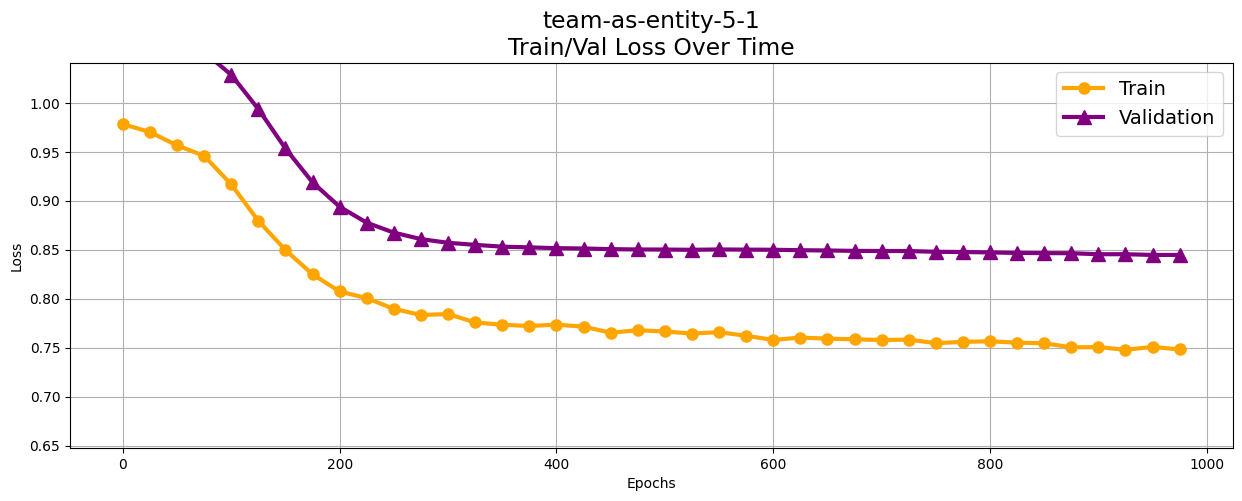

In [11]:
for res in  results:
    plot_train_v_loss(f"team-as-entity-{res[0][0]}-{res[0][1]}", res[1][1], res[1][2], loss_interval)

# Exploration results

Exploration for the team-as-entity model by varying the number of stacked LSTM layers and the number of hidden features. Apparently adding stacked LSTM layers for the same number of hidden features makes the loss decrease slower, but they all reach about the same loss plateau of 0.25. Adding more hidden layers makes the loss decrease faster, but once again it still plateau around 0.25. 

5
(tensor([[-0.7077,  0.5919],
        [-0.9711,  0.8362],
        [-1.4589,  1.3761],
        ...,
        [ 0.9137, -0.9087],
        [ 1.0564, -1.0444],
        [ 1.0587, -1.0481]]), tensor([[-2.5478,  2.7582],
        [-2.3147,  2.6354],
        [-2.3147,  1.7753],
        ...,
        [ 1.7646, -1.5421],
        [ 1.5315, -1.4193],
        [ 1.2052, -0.8994]]))


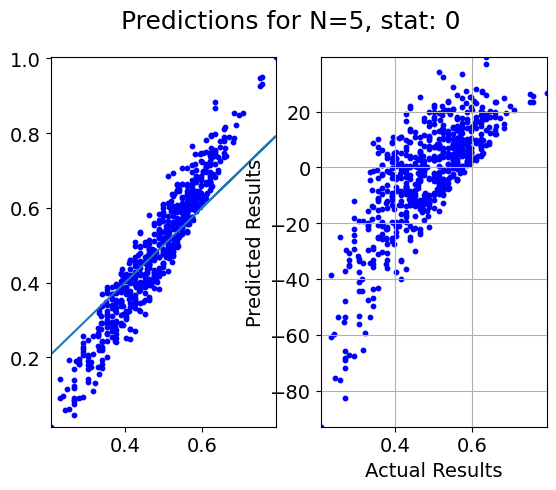

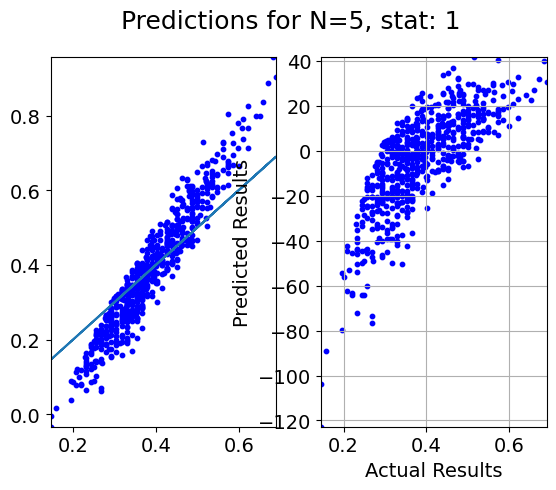

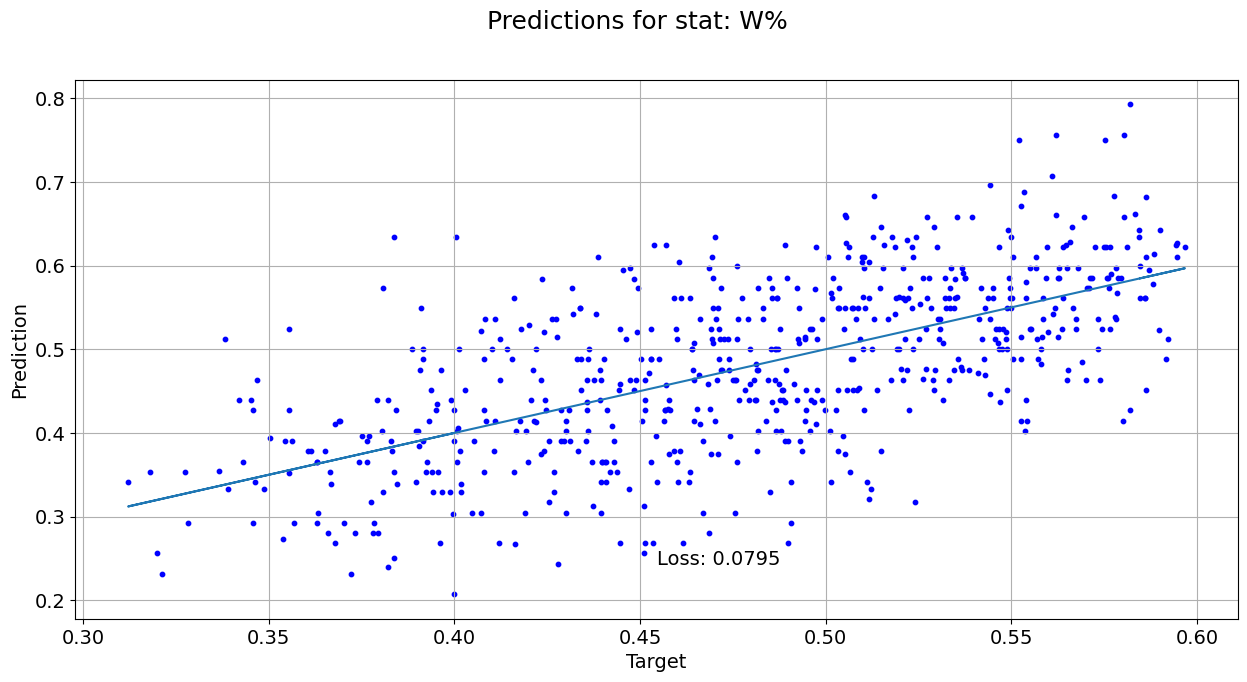

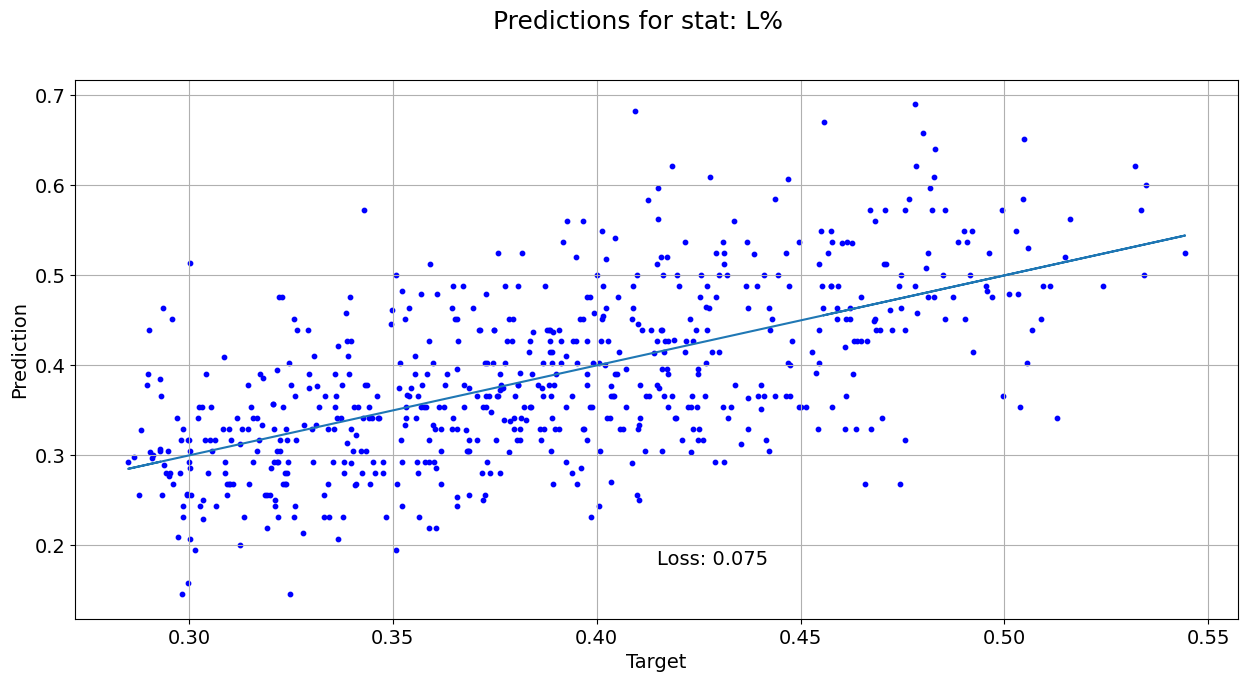

In [14]:
preds_n_targets = get_targets_preds_pairs(dataset, model, device)

#unnormalize
for pair in preds_n_targets:
    target = dataset.unnormalize(preds_n_targets[pair][0]) 
    pred = dataset.unnormalize(preds_n_targets[pair][1])
    preds_n_targets[pair] = (target, pred)
    
plot_divergence(dataset.NL, preds_n_targets, criterion)
plot_correlation(dataset.NL, preds_n_targets, criterion, dataset.col_names)